# IMPORTING PACKAGES

In [ ]:
import pandas as pd
import numpy as np
import pywt
from sklearn.model_selection import train_test_split
import scipy.signal
from keras.models import Sequential
from keras.layers import LSTM, Dense, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import ConvLSTM1D, Flatten, Dense
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt

# DATA PREPROCESSING

In [ ]:
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [ ]:
data = dataframe.drop(140, axis=1)
ecg_data = pd.Series([item for sublist in data.values for item in sublist])
min_val = ecg_data.min()
max_val = ecg_data.max()
correct_value = ecg_data[99860:100140]
ecg_data = ecg_data[:100000]

In [ ]:
def normalise(data):
  data = (data - min_val) / (max_val - min_val)
  return data

In [ ]:
ecg_data = normalise(ecg_data)
correct_value = normalise(correct_value)

# FEATURE EXTRACTION

In [ ]:
x = []
y = []

for i in range(140, len(ecg_data)):
  features = ecg_data.iloc[i-140:i]
  target = ecg_data.iloc[i]

  x.append(features.values.reshape(1, -1))
  y.append(target)

x = np.array(x)
y = np.array(y)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [ ]:
x_train.shape

(79888, 1, 140)

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[2], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[2], 1))

In [ ]:
x_train = x_train.reshape((x_train.shape[0], 1, 140, 1))
x_test = x_test.reshape((x_test.shape[0], 1, 140, 1))

# RESULT FUNCTIONS


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
  epsilon = 1e-7
  return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon)) * 100)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,accuracy_score
from math import log
def metrics(y_pred):
  r2 = r2_score(y_test,y_pred)
  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test,y_pred)
  rmse = np.sqrt(mse)
  mape = mean_absolute_percentage_error(y_test, y_pred)
  print("MSE :", mse)
  print("MAE :" ,mae)
  print("RMSE :" ,rmse)
  print("R2_score :",r2)
  print("MAPE :" ,mape)

In [ ]:
def predict_convlstm():
  last_data = ecg_data.tail(140)
  last_data = last_data.to_numpy()
  result = []
  prediction_steps = 140
  for i in range(prediction_steps):
    prediction = convlstm_model.predict(last_data.reshape(-1, 1, 140, 1))[0][0]
    result.append(prediction)
    last_data = np.append(last_data[1:], prediction)
  return result

In [ ]:
def predict_cnnlstm():
  last_data = ecg_data.tail(140)
  last_data = last_data.to_numpy()
  result = []
  prediction_steps = 140
  for i in range(prediction_steps):
    prediction = CNN_LSTM.predict(last_data.reshape(-1, 1, 140, 1))[0][0]
    result.append(prediction)
    last_data = np.append(last_data[1:], prediction)
  return result

In [ ]:
def plot_graph(result):
  last_actual_data = ecg_data.tail(140)
  all_values = last_actual_data.tolist()
  all_values.extend(result)
  actual_values = all_values[:140]
  predicted_values = all_values[140:]
  time_axis = np.arange(len(all_values))

  plt.figure(figsize=(15, 5))

  plt.plot(time_axis[:140], actual_values, label='Actual Heartbeat')
  plt.plot(time_axis[140:], predicted_values, label='Predicted Heartbeat', linestyle='-')
  plt.axvline(x=140, color='r', linestyle='--', linewidth=1, label='Prediction Start')

  plt.xlabel('Time (seconds)')
  plt.ylabel('Heartbeat Value')
  plt.title('Actual and Predicted Heartbeat Values (140 seconds)')
  plt.legend()
  plt.grid(True)

  plt.fill_between(time_axis[140:], predicted_values, np.min(all_values), alpha=0.2, color='lightcoral')

  plt.show()

# ConvLSTM - MODEL

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, ConvLSTM1D, MaxPooling2D,Dropout

In [ ]:
convlstm_model = Sequential()
convlstm_model.add(ConvLSTM1D(filters=64, kernel_size=1, input_shape=(1, 140, 1), return_sequences=True))
convlstm_model.add(ConvLSTM1D(filters=64, kernel_size=1, return_sequences=True))
convlstm_model.add(ConvLSTM1D(filters=64, kernel_size=1))
convlstm_model.add(Flatten())
convlstm_model.add(Dense(64, activation='relu'))
convlstm_model.add(Dropout(0.2))
convlstm_model.add(Dense(1))

In [ ]:
convlstm_model.compile(optimizer='adam',loss='mse',metrics=['mae', 'mse' ])

# ConvLSTM - 30 EPOCHS

In [ ]:
history = convlstm_model.fit(
    x_train, y_train,
    epochs=30,
    batch_size=16,validation_data=(x_test, y_test)
)

In [ ]:
convlstm_model.save("convlstm1d30.h5")

In [ ]:
import tensorflow as tf
convlstm_model = tf.keras.models.load_model('/content/convlstm1d30.h5')

In [ ]:
y_pred = convlstm_model.predict(x_test)
metrics(y_pred)

625/625 [==============================] - 22s 34ms/step
MSE : 0.0012030922521757824
MAE : 0.0266584893277377
RMSE : 0.03468562025070018
R2_score : 0.7434539324441409
MAE : 16.583656383585875


In [ ]:
result_1 = predict_convlstm()

1/1 [==============================] - 0s 34ms/step


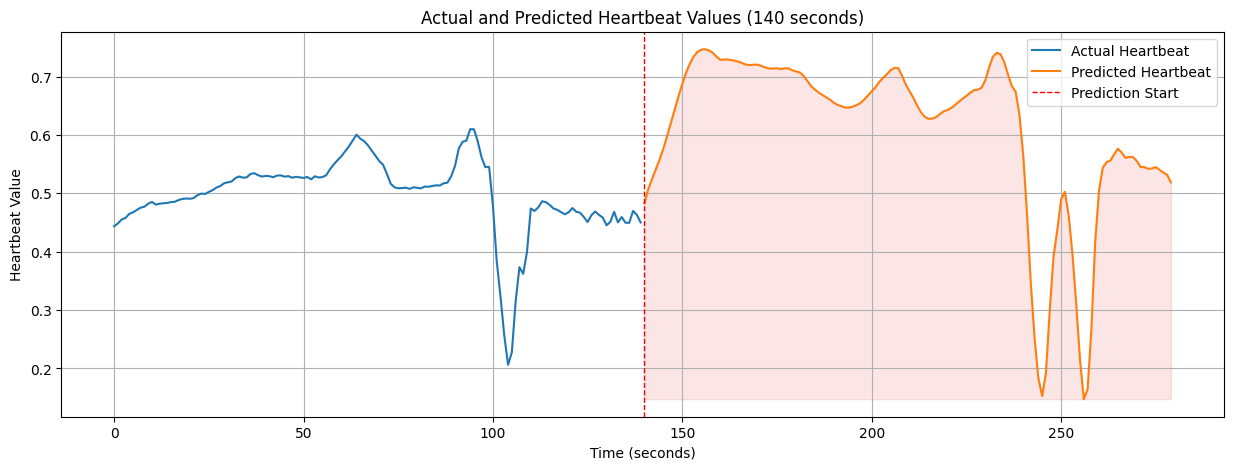

In [ ]:
plot_graph(result_1)

# ConvLSTM - 20 EPOCHS

In [ ]:
history = convlstm_model.fit(
    x_train, y_train,
    epochs=20,
    batch_size=16,validation_data=(x_test, y_test)
)

Epoch 1/20
4993/4993 [==============================] - 78s 14ms/step - loss: 0.0024 - mae: 0.0325 - mse: 0.0024 - val_loss: 5.0538e-04 - val_mae: 0.0136 - val_mse: 5.0538e-04
Epoch 2/20
4993/4993 [==============================] - 71s 14ms/step - loss: 6.1403e-04 - mae: 0.0156 - mse: 6.1403e-04 - val_loss: 3.6776e-04 - val_mae: 0.0108 - val_mse: 3.6776e-04
Epoch 3/20
4993/4993 [==============================] - 68s 14ms/step - loss: 5.0141e-04 - mae: 0.0135 - mse: 5.0141e-04 - val_loss: 3.7952e-04 - val_mae: 0.0110 - val_mse: 3.7952e-04
Epoch 4/20
4993/4993 [==============================] - 67s 13ms/step - loss: 4.6455e-04 - mae: 0.0128 - mse: 4.6455e-04 - val_loss: 3.4745e-04 - val_mae: 0.0100 - val_mse: 3.4745e-04
Epoch 5/20
4993/4993 [==============================] - 66s 13ms/step - loss: 4.3495e-04 - mae: 0.0122 - mse: 4.3495e-04 - val_loss: 3.5351e-04 - val_mae: 0.0107 - val_mse: 3.5351e-04
Epoch 6/20
4993/4993 [==============================] - 69s 14ms/step - loss: 4.3288e-04

In [ ]:
convlstm_model.save("convlstm11d20.h5")

In [ ]:
import tensorflow as tf
convlstm_model = tf.keras.models.load_model('/content/convlstm11d20.h5')

In [ ]:
y_pred = convlstm_model.predict(x_test)
metrics(y_pred)

625/625 [==============================] - 4s 5ms/step
MSE : 0.000263631398271626
MAE : 0.008339645322841479
RMSE : 0.016236729913120623
R2_score : 0.9437835308235729
MAPE : 15.750325642408395


In [ ]:
result = predict_convlstm()

In [ ]:
plot_graph(result)

# ConvLSTM - 15 EPOCHS

In [ ]:
history = convlstm_model.fit(
    x_train, y_train,
    epochs=15,
    batch_size=16,validation_data=(x_test, y_test)
)

In [ ]:
convlstm_model.save("convlstm1d15.h5")

In [ ]:
import tensorflow as tf
convlstm_model = tf.keras.models.load_model('/content/convlstm1d15.h5')

In [ ]:
y_pred = convlstm_model.predict(x_test)
metrics(y_pred)

625/625 [==============================] - 3s 4ms/step
MSE : 0.00024890906582993055
MAE : 0.007804983423713248
RMSE : 0.015776852215506443
R2_score : 0.9469229047879022
MAPE : 15.918789352519543


In [ ]:
result = predict_convlstm()

In [ ]:
plot_graph(result)

# CNN + LSTM - MODEL

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, ConvLSTM1D, MaxPooling2D
from tensorflow.keras.layers import Conv1D,Dropout, LSTM, Dense

In [ ]:
CNN_LSTM = Sequential()
CNN_LSTM.add(Conv1D(filters=64, kernel_size=3, activation="relu", input_shape=(140, 1)))
CNN_LSTM.add(LSTM(64, return_sequences=True))
CNN_LSTM.add(LSTM(32))
CNN_LSTM.add(Dense(1))
CNN_LSTM.compile(loss="mse", optimizer="adam",metrics=['mae', 'mse'])

In [ ]:
x_train = x_train.reshape((x_train.shape[0], 140, 1))
x_test = x_test.reshape((x_test.shape[0], 140, 1))

# CNN + LSTM - 30 EPOCHS

In [ ]:
history = CNN_LSTM.fit(
    x_train, y_train,
    epochs=30,
    batch_size=16,
    validation_data=(x_test, y_test)
)

In [ ]:
CNN_LSTM.save("cnn_lstm30.h5")

In [ ]:
import tensorflow as tf
CNN_LSTM = tf.keras.models.load_model('/content/cnn_lstm30.h5')

In [ ]:
y_pred = CNN_LSTM.predict(x_test)
metrics(y_pred)

625/625 [==============================] - 4s 6ms/step
MSE : 0.0002135559235401985
MAE : 0.006989587579339393
RMSE : 0.014613552735053804
R2_score : 0.9544615699349606
MAPE : 15.925386634333059


In [ ]:
result_2 = predict_cnnlstm()

In [ ]:
plot_graph(result_2)

# CNN + LSTM - 20 EPOCHS

In [ ]:
history = CNN_LSTM.fit(
    x_train, y_train,
    epochs=20,
    batch_size=16,
    validation_data=(x_test, y_test)
)

In [ ]:
CNN_LSTM.save("cnn_lstm20.h5")

In [ ]:
import tensorflow as tf
CNN_LSTM = tf.keras.models.load_model('/content/cnn_lstm20.h5')

In [ ]:
y_pred = CNN_LSTM.predict(x_test)
metrics(y_pred)

625/625 [==============================] - 4s 6ms/step
MSE : 0.00022175016916224527
MAE : 0.007707833704999184
RMSE : 0.014891278291746659
R2_score : 0.9527142380182925
MAPE : 16.01547088004883


In [ ]:
result = predict_cnnlstm()

In [ ]:
plot_graph(result)

# CNN + LSTM - 15 EPOCHS

In [ ]:
history = CNN_LSTM.fit(
    x_train, y_train,
    epochs=15,
    batch_size=8,
    validation_data=(x_test, y_test)
)

In [ ]:
CNN_LSTM.save("cnn_lstm15.h5")

In [ ]:
import tensorflow as tf
CNN_LSTM = tf.keras.models.load_model('/content/cnn_lstm15.h5')

In [ ]:
y_pred = CNN_LSTM.predict(x_test)
metrics(y_pred)

625/625 [==============================] - 4s 6ms/step
MSE : 0.000209356472902641
MAE : 0.006808747760217988
RMSE : 0.014469155915347687
R2_score : 0.9553570561663879
MAPE : 15.696206195516972


In [ ]:
result = predict_cnnlstm()

In [ ]:
plot_graph(result)

# ANOMALY DETECTION - DATA PREPROCESSING

In [ ]:
from tensorflow.keras.utils import to_categorical  # Utility for one-hot encoding

In [ ]:
data = dataframe.iloc[:,:-1]
labels = dataframe.iloc[:,-1]

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=21)

In [ ]:
def normalize_ecg_data(data):
  min_val = np.min(data)
  max_val = np.max(data)
  return (data - min_val) / (max_val - min_val)
  data = (data - min_val) / (max_val - min_val)
  data = tf.cast(data, tf.float32)
  return data

In [ ]:
train_data = normalize_ecg_data(train_data)
test_data = normalize_ecg_data(test_data)

In [ ]:
sequence_length = 140  # Length of ECG sequences in ECG5000
num_features = 1  # Assuming single-channel ECG data
num_classes = 2
epochs = 10
batch_size = 32

In [ ]:
from tensorflow.keras.layers import Conv1D, Dropout, LSTM, Dense  # Model layers

# ANOMALY DETECTION - MODEL BUILDING

In [ ]:
model = Sequential([
  Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(sequence_length, num_features)),
  Dropout(0.2),
  LSTM(units=64, return_sequences=True),  # Use LSTM for temporal dependencies
  Dropout(0.2),
  LSTM(units=32),
  Dropout(0.2),
  Dense(units=2, activation='sigmoid')
])

In [ ]:
train_labels = to_categorical(train_labels)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size)


Epoch 1/10
125/125 [==============================] - 24s 153ms/step - loss: 0.3284 - accuracy: 0.8337
Epoch 2/10
125/125 [==============================] - 18s 145ms/step - loss: 0.0876 - accuracy: 0.9722
Epoch 3/10
125/125 [==============================] - 19s 153ms/step - loss: 0.0808 - accuracy: 0.9760
Epoch 4/10
125/125 [==============================] - 18s 145ms/step - loss: 0.0619 - accuracy: 0.9817
Epoch 5/10
125/125 [==============================] - 20s 163ms/step - loss: 0.0556 - accuracy: 0.9822
Epoch 6/10
125/125 [==============================] - 19s 148ms/step - loss: 0.0514 - accuracy: 0.9845
Epoch 7/10
125/125 [==============================] - 19s 153ms/step - loss: 0.0535 - accuracy: 0.9845
Epoch 8/10
125/125 [==============================] - 18s 146ms/step - loss: 0.0530 - accuracy: 0.9857
Epoch 9/10
125/125 [==============================] - 19s 156ms/step - loss: 0.0489 - accuracy: 0.9855
Epoch 10/10
125/125 [==============================] - 18s 145ms/step - l

In [ ]:
model.save("Anomaly_Detection.h5")

# ANOMALY DETECTION - PREDICTION

In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model('/content/Anomaly_Detection.h5')

In [ ]:
result_1_arr = np.array(result_1)
result_2_arr = np.array(result_2)

In [ ]:
reshaped_arr1 = result_1_arr.reshape(1,140,1)
reshaped_arr2 = result_2_arr.reshape(1,140,1)

In [ ]:
prediction1 = model.predict(reshaped_arr1)
prediction2 = model.predict(reshaped_arr2)

In [ ]:
predicted_class1 = np.argmax(prediction1, axis=1)
predicted_class2 = np.argmax(prediction2, axis=1)

In [ ]:
def output(predicted_class,model):
  if(predicted_class == 1):
    print(model + " is a Normal Signal")
  else:
    print(model + " is a Anomaly Signal")

In [ ]:
output(predicted_class1[0],"convlstm")
output(predicted_class2[0],"cnn+lstm")

# ANALYSIS BETWEEN MODELS


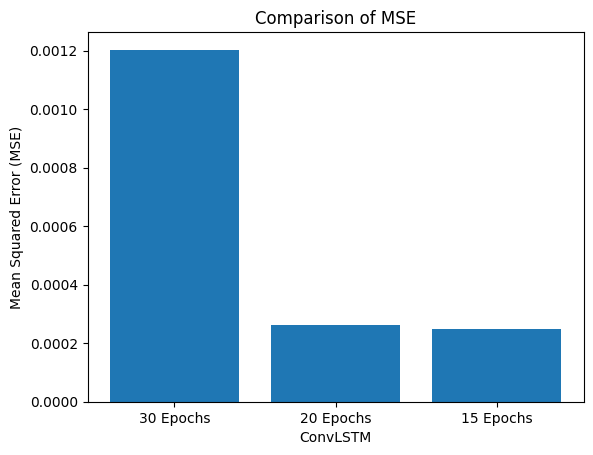

In [ ]:
model_names = ["30 Epochs", "20 Epochs", "15 Epochs"]

mse_values = [0.001203, 0.0002636, 0.0002489]

plt.bar(model_names, mse_values)
plt.xlabel("ConvLSTM")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Comparison of MSE")
plt.show()

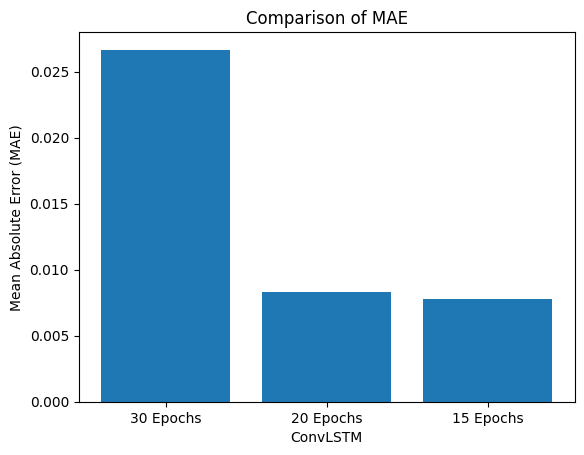

In [ ]:
model_names = ["30 Epochs", "20 Epochs", "15 Epochs"]

mae_values = [0.026658, 0.0083396, 0.0078049]

plt.bar(model_names, mae_values)
plt.xlabel("ConvLSTM")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Comparison of MAE")
plt.show()

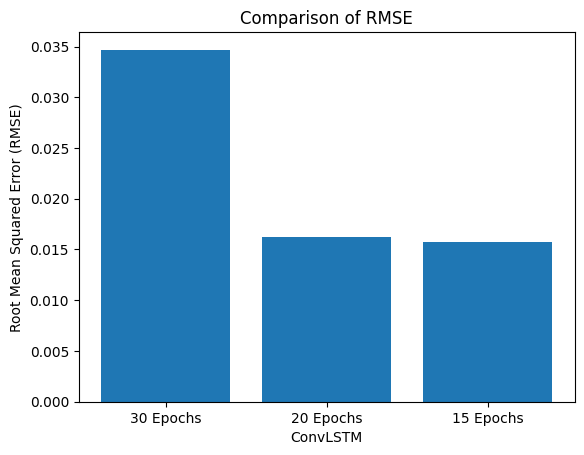

In [ ]:
model_names = ["30 Epochs", "20 Epochs", "15 Epochs"]

values = [0.0346856, 0.01623672, 0.0157768]

plt.bar(model_names, values)
plt.xlabel("ConvLSTM")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("Comparison of RMSE")
plt.show()

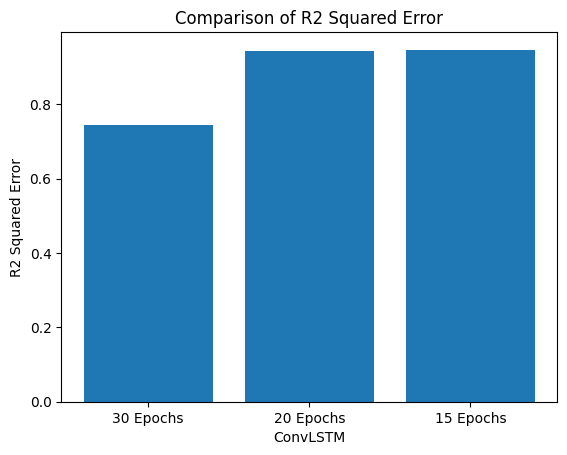

In [ ]:
model_names = ["30 Epochs", "20 Epochs", "15 Epochs"]

values = [0.743453, 0.94378353, 0.9469229]

plt.bar(model_names, values)
plt.xlabel("ConvLSTM")
plt.ylabel("R2 Squared Error")
plt.title("Comparison of R2 Squared Error")
plt.show()

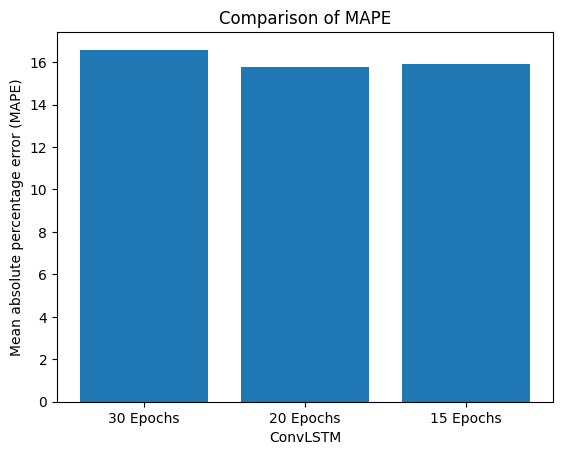

In [ ]:
model_names = ["30 Epochs", "20 Epochs", "15 Epochs"]

values = [16.58365, 15.7503256, 15.918789]

plt.bar(model_names, values)
plt.xlabel("ConvLSTM")
plt.ylabel("Mean absolute percentage error (MAPE)")
plt.title("Comparison of MAPE")
plt.show()

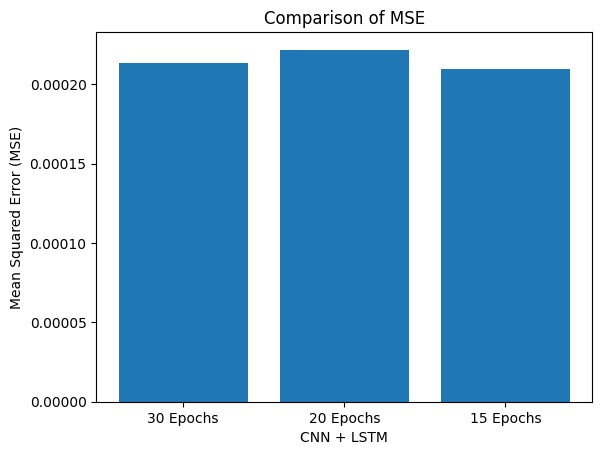

In [ ]:
model_names = ["30 Epochs", "20 Epochs", "15 Epochs"]

mse_values = [0.00021355, 0.00022175, 0.0002093]

plt.bar(model_names, mse_values)
plt.xlabel("CNN + LSTM")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Comparison of MSE")
plt.show()

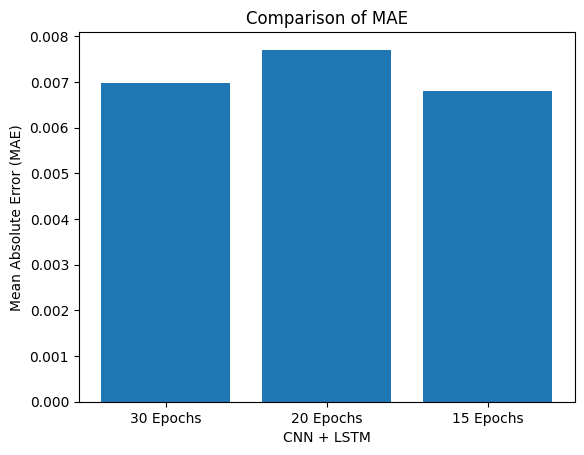

In [ ]:
model_names = ["30 Epochs", "20 Epochs", "15 Epochs"]

mae_values = [0.00698958, 0.00770783, 0.0068087]

plt.bar(model_names, mae_values)
plt.xlabel("CNN + LSTM")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Comparison of MAE")
plt.show()

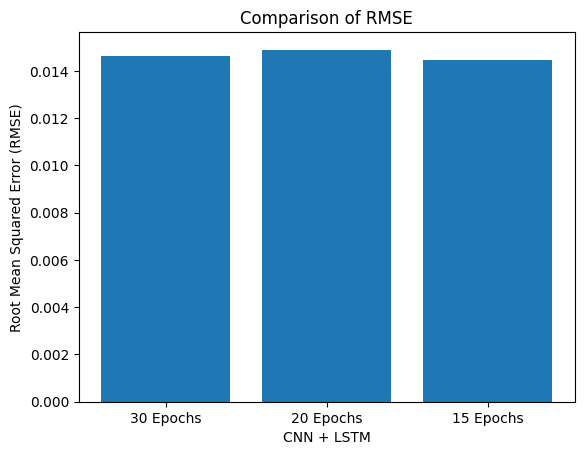

In [ ]:
model_names = ["30 Epochs", "20 Epochs", "15 Epochs"]

values = [0.01461355, 0.01489127, 0.01446915]

plt.bar(model_names, values)
plt.xlabel("CNN + LSTM")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("Comparison of RMSE")
plt.show()

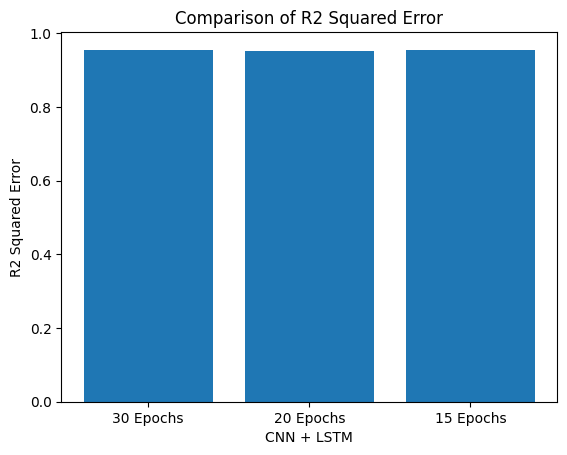

In [ ]:
model_names = ["30 Epochs", "20 Epochs", "15 Epochs"]

values = [0.95446156, 0.95271423, 0.95535705]

plt.bar(model_names, values)
plt.xlabel("CNN + LSTM")
plt.ylabel("R2 Squared Error")
plt.title("Comparison of R2 Squared Error")
plt.show()

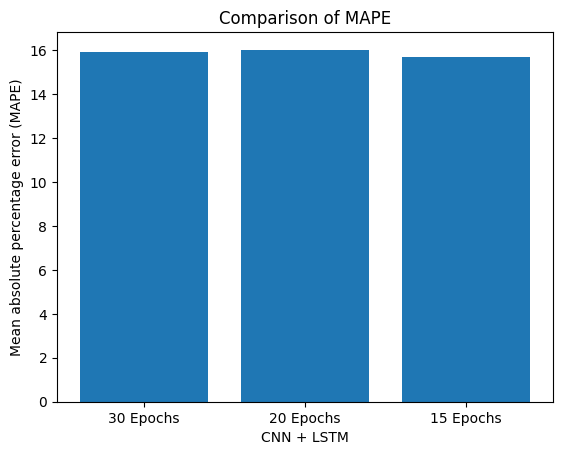

In [ ]:
model_names = ["30 Epochs", "20 Epochs", "15 Epochs"]

values = [15.9253866, 16.0154708, 15.696206]

plt.bar(model_names, values)
plt.xlabel("CNN + LSTM")
plt.ylabel("Mean absolute percentage error (MAPE)")
plt.title("Comparison of MAPE")
plt.show()

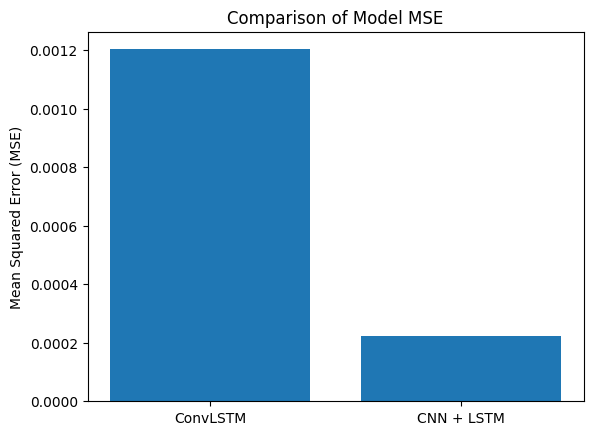

In [ ]:
model_names = ["ConvLSTM", "CNN + LSTM"]

mse_values = [0.001203, 0.00022175]

plt.bar(model_names, mse_values)
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Comparison of Model MSE")
plt.show()

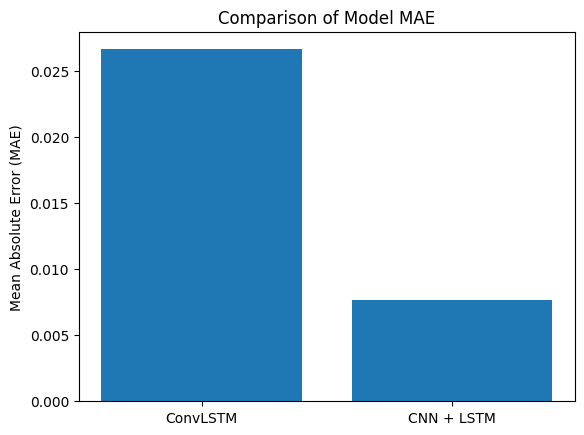

In [ ]:
model_names = ["ConvLSTM", "CNN + LSTM"]

mse_values = [0.026658, 0.00770783]

plt.bar(model_names, mse_values)
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Comparison of Model MAE")
plt.show()

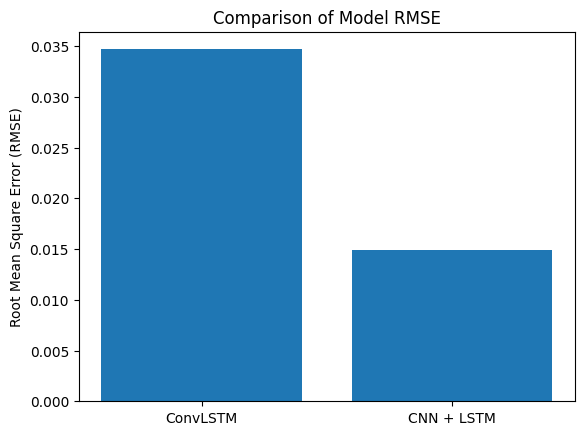

In [ ]:
model_names = ["ConvLSTM", "CNN + LSTM"]

mse_values = [0.0346856, 0.01489127]

plt.bar(model_names, mse_values)
plt.ylabel("Root Mean Square Error (RMSE)")
plt.title("Comparison of Model RMSE")
plt.show()

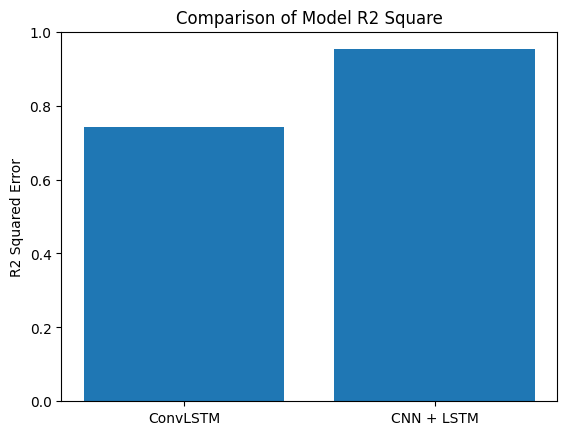

In [ ]:
model_names = ["ConvLSTM", "CNN + LSTM"]

mse_values = [0.743453, 0.95271423]

plt.bar(model_names, mse_values)
plt.ylabel("R2 Squared Error")
plt.title("Comparison of Model R2 Square")
plt.show()

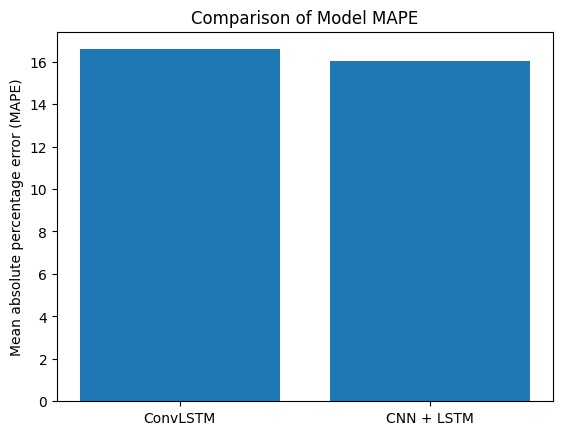

In [ ]:
model_names = ["ConvLSTM", "CNN + LSTM"]

mse_values = [16.58365, 16.0154708]

plt.bar(model_names, mse_values)
plt.ylabel("Mean absolute percentage error (MAPE)")
plt.title("Comparison of Model MAPE")
plt.show()